In [547]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import json

In [548]:
num_day = 1

In [549]:
json_path = f'train/day-{num_day}.json'
with open(json_path, "r") as f:
    data = json.load(f)

In [552]:
print(f'День {num_day}')
print('Кол-во печей {}, кол-во серий {}'.format(len(data['ovens']), len(data['series'])))

День 1
Кол-во печей 467, кол-во серий 1697


### EDA для печей

In [503]:
start_temp = []
working_temps = []
operations = []

for i in data['ovens']:
    start_temp.append(i['start_temp'])
    working_temps.append(i['working_temps'])
    operations.append(i['operations'])

hist_operation = pd.Series(operations).apply(lambda x: set(x)).value_counts()
hist_start_temp = pd.Series(start_temp).value_counts().sort_index()

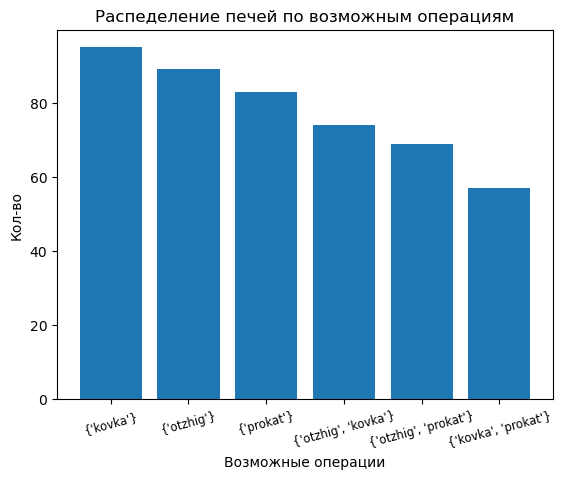

In [557]:
plt.bar(range(len(hist_operation)), hist_operation.values, align='center')
plt.xticks(range(len(hist_operation)), hist_operation.index.values, size='small')
plt.title('Распеделение печей по возможным операциям')
plt.xlabel('Возможные операции')
plt.xticks(rotation=15)
plt.ylabel('Кол-во')
plt.show()

### Вывод №1
Анализируя распределение кол-ва печей по возможным операциям делаем вывод, что ковка - самая распространенная операция, далее отжиг, и наименее распространенная операция - прокат. Отсюда можно сделать утверждение, что операцию прокат, труднее всего выполнить, т.к печей с данной операцией меньше всего.

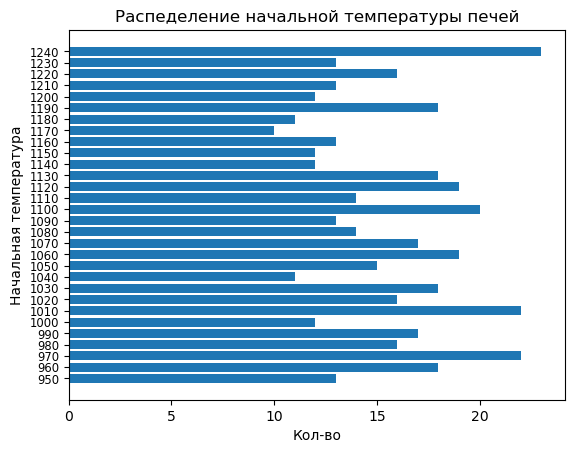

In [505]:
plt.barh(range(len(hist_start_temp)), hist_start_temp.values, align='center')
plt.yticks(range(len(hist_start_temp)), hist_start_temp.index.values, size='small')
plt.title('Распеделение начальной температуры печей')
plt.xlabel('Кол-во')
plt.ylabel('Начальная температура')
plt.show()

In [506]:
unique_temp = pd.Series(working_temps).apply(lambda x: set(x)).value_counts()
print('Уникальные диапазоны температур для печей - {} шт.'.format(len(unique_temp)))

Уникальные диапазоны температур для печей - 455 шт.


In [507]:
unique_temp

{1090, 1220, 1060, 1160, 1100, 1040, 1170, 950, 1080, 1020}    3
{1090, 1220, 1000, 1130, 1100, 1200, 1010, 1110, 1150}         2
{1170, 1190, 1090, 1070}                                       2
{960, 1190, 1160, 1100, 950, 1110, 1240, 1180}                 2
{1120, 1090, 1060, 1130, 1080}                                 2
                                                              ..
{1190, 970, 1230, 1070, 1200, 1010, 1140, 990, 950, 1150}      1
{960, 1220, 1030, 1100, 1170}                                  1
{1100, 1230, 1070, 1040, 1200, 1010, 1210, 1020, 990}          1
{1220, 1060, 1040, 1170, 1010, 1240, 1180, 1150}               1
{1120, 1030, 970, 1070, 1230, 1040, 980, 950, 1080, 1210}      1
Name: count, Length: 455, dtype: int64

Распределение начальных температур печей неинформативно, позволяют только определить состояние печи на момент начала работы. Кол-во уникальных наборов диапазон температур практически совпадает с кол-вом печей. Кол-во печей - 467, уникальные диапазоны температур - 455 шт. Т.е только 12 печей имеют дубликаты.

### EDA для операций

In [508]:
data['series'][0], data['series'][1]

({'temperature': 970,
  'operations': [{'name': 'nagrev', 'timing': 62},
   {'name': 'otzhig', 'timing': 15}]},
 {'temperature': 1080,
  'operations': [{'name': 'nagrev', 'timing': 245},
   {'name': 'prokat', 'timing': 15}]})

Датафрейм для каждой серии с продолжительностью операций

In [509]:
work_temp = []
time_one_series = []
time_operation_ = []
for i in data['series']:
    work_temp.append(i['temperature'])
    time_cur = 0
    time_othig = 0
    time_nagrev = 0
    time_prokat = 0
    for k in i['operations']:        
        if k['name'] == 'otzhig':
            time_othig = k['timing']
        elif k['name'] == 'nagrev':
            time_nagrev = k['timing']           
        elif k['name'] == 'prokat':
            time_prokat = k['timing']
        time_cur += k['timing']
    time_one_series.append(time_cur)
    time_operation_.append([time_nagrev, time_othig, time_prokat])
    
df_series_ = pd.DataFrame(index = range(len(work_temp)),
                          columns=['work_temp','time_nagrev', 'time_otzhig', 'time_prokat', 'total_time'])

df_series_['work_temp'] = work_temp
df_series_['time_nagrev'] = np.array(time_operation_)[:,0]
df_series_['time_otzhig'] = np.array(time_operation_)[:,1]
df_series_['time_prokat'] = np.array(time_operation_)[:,2]
df_series_['total_time'] = time_one_series

In [511]:
df_series_.head(5)

,work_temp,time_nagrev,time_otzhig,time_prokat,total_time
0,970,62,15,0,77
1,1080,245,0,15,260
2,980,96,15,0,111
3,1080,76,0,0,91
4,1040,213,0,15,228


Анализ полученного датафрейма

In [512]:
total_time = df_series_['total_time'].sum()
total_time_nagrev = df_series_['time_nagrev'].sum()
total_time_otzhig = df_series_['time_otzhig'].sum()
total_time_prokat = df_series_['time_prokat'].sum()
print('Кол-во минут в сутках - {}'.format(1440))
print('Cуммарное кол-во времени операций для всех серий {} минут'.format(total_time))
print('Cуммарное кол-во времени операции - нагрев для всех серий {} минут'.format(total_time_nagrev))
print('Cуммарное кол-во времени операции - отжиг для всех серий {} минут'.format(total_time_otzhig))
print('Cуммарное кол-во времени операции - прокат для всех серий {} минут'.format(total_time_prokat))

Кол-во минут в сутках - 1440
Cуммарное кол-во времени операций для всех серий 318368 минут
Cуммарное кол-во времени операции - нагрев для всех серий 285023 минут
Cуммарное кол-во времени операции - отжиг для всех серий 8685 минут
Cуммарное кол-во времени операции - прокат для всех серий 8670 минут


In [558]:
unique_temp_ = len(df_series_['work_temp'].unique())
print('Кол-во уникальных температур для cерий {}'.format(unique_temp_))

Кол-во уникальных температур для cерий 15


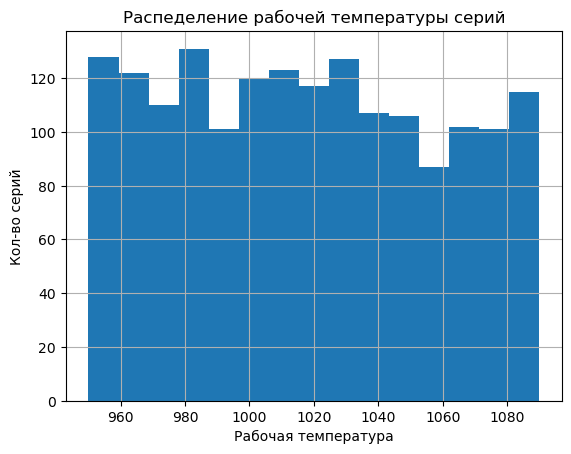

In [514]:
df_series_['work_temp'].hist(bins=unique_temp_)
plt.title('Распеделение рабочей температуры серий')
plt.xlabel('Рабочая температура')
plt.ylabel('Кол-во серий')
plt.show()

Распределение по температурам серий на день имеет нормальный вид.

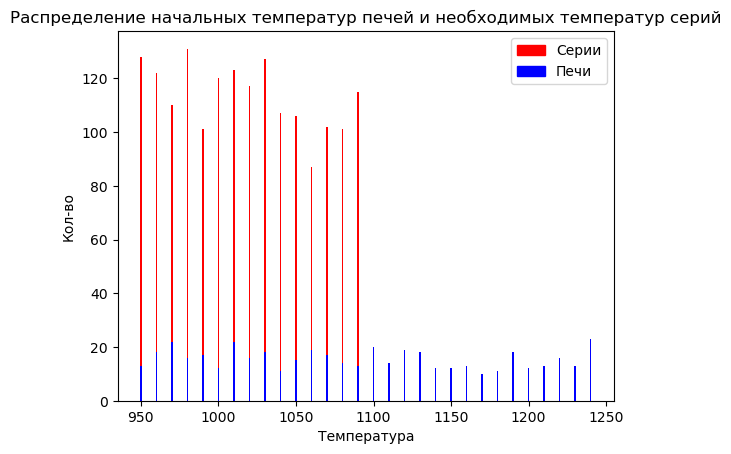

In [516]:
hist_series_temp = df_series_['work_temp'].value_counts()

plt.bar(x = hist_series_temp.index, height = hist_series_temp.values, color='red')
plt.bar(x = hist_start_temp.index, height = hist_start_temp.values, color='blue')
pop_a = mpatches.Patch(color='red', label='Серии') 
pop_b = mpatches.Patch(color='blue', label='Печи') 
plt.legend(handles=[pop_a,pop_b]) 
plt.title('Распределение начальных температур печей и необходимых температур серий')
plt.xlabel('Температура')
plt.ylabel('Кол-во')

plt.show()

### Вывод №2
На графике распределения начальных температур печей и необходимых температур серий заметно, что часть печей находятся в температурном диапазоне не попадающий в диапазон серий.

Cгруппированный датасет по температурам серий, показывающий суммарное время каждой операции.

In [517]:
group_df = df_series_.groupby('work_temp')[df_series_.columns[1:]].sum().reset_index()
group_df

,work_temp,time_nagrev,time_otzhig,time_prokat,total_time
0,950,20369,675,720,22794
1,960,21990,705,435,24510
2,970,19693,525,645,21818
3,980,21599,735,585,24119
4,990,16721,600,435,18746
5,1000,20081,555,690,22466
6,1010,20411,675,570,22746
7,1020,20543,570,645,22683
8,1030,20550,540,675,23275
9,1040,17774,615,570,19759


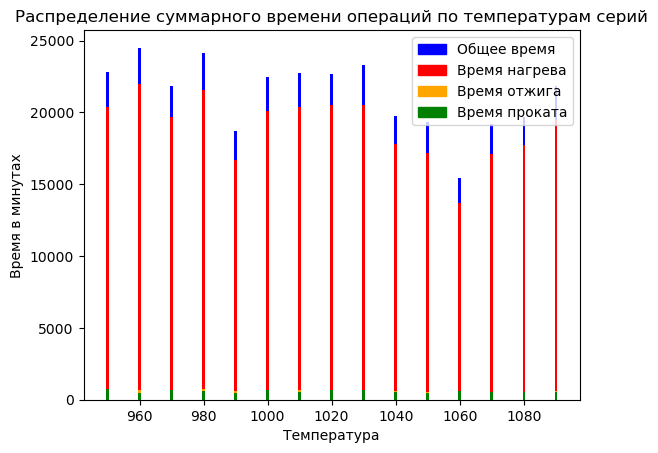

In [559]:
plt.bar(x = group_df['work_temp'], height = group_df['total_time'], color='blue')
plt.bar(x = group_df['work_temp'], height = group_df['time_nagrev'], color='red')
plt.bar(x = group_df['work_temp'], height = group_df['time_otzhig'], color='orange')
plt.bar(x = group_df['work_temp'], height = group_df['time_prokat'], color='green')

pop_a = mpatches.Patch(color='blue', label='Общее время') 
pop_b = mpatches.Patch(color='red', label='Время нагрева')
pop_c = mpatches.Patch(color='orange', label='Время отжига') 
pop_d = mpatches.Patch(color='green', label='Время проката') 
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d]) 

plt.title('Распределение суммарного времени операций по температурам серий')
plt.xlabel('Температура')
plt.ylabel('Время в минутах')
plt.show()

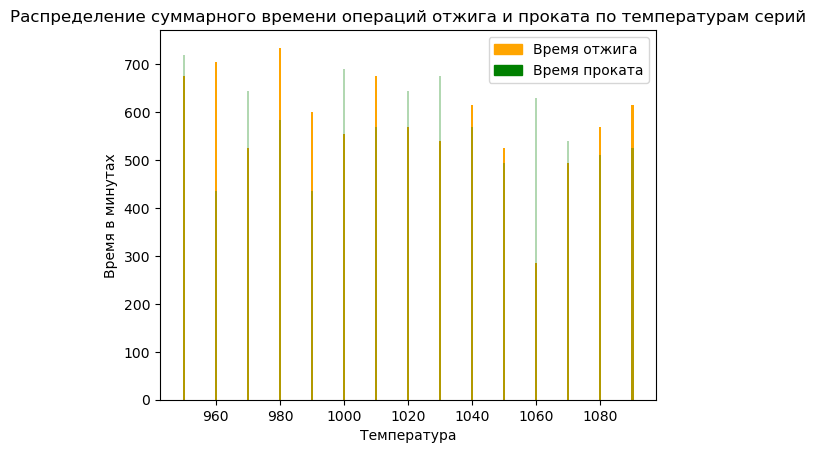

In [560]:
plt.bar(x = group_df['work_temp'], height = group_df['time_otzhig'], color='orange')
plt.bar(x = group_df['work_temp'], height = group_df['time_prokat'], color='green', alpha=0.3)

pop_c = mpatches.Patch(color='orange', label='Время отжига') 
pop_d = mpatches.Patch(color='green', label='Время проката') 
plt.legend(handles=[pop_c,pop_d]) 

plt.title('Распределение суммарного времени операций отжига и проката по температурам серий')
plt.xlabel('Температура')
plt.ylabel('Время в минутах')
plt.show()